In [14]:
#数据准备
import os
import pandas as pd
import re
 
 
file_path ="D:/liliyuan/app/WeChat/WeChat Files/wxid_js986i8atpat22/FileStorage/File/2025-04/11.xlsx"
data=pd.read_excel(file_path)
stop_file = 'D:/program/code/LDA/stop_words.txt'  
with open(stop_file, 'r', encoding='utf-8') as file:
    custom_stopwords = set(file.read().splitlines())

In [15]:
from nltk.stem import PorterStemmer
# 读取自定义停用词表文档
stopwords_file_path = 'D:/program/code/LDA/stop_words.txt'  
with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    custom_stopwords = set(file.read().splitlines())
# 去除特殊字符和数字
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)
# 转换为小写
def to_lowercase(text):
    return text.lower()
# 去除停用词
def remove_stopwords(text):
    stop_words = custom_stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# 词干化
def stem_text(text):
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)
# 对title文本内容进行数据处理
def preprocess_text(text):
    text = remove_special_characters(text)
    text = to_lowercase(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text


data['processed_sentence'] = data['sentence'].apply(preprocess_text)

# 输出前10个结果
print(data.head(10))

                                               title  \
0  Evolution and effect of meeting abstracts in J...   
1  A framework armed with node dynamics for predi...   
2  Scientific knowledge role transition predictio...   
3  Analysis of the distribution of authorship by ...   
4  Development and application of a comprehensive...   
5  Technological recombinant strategy and breakth...   
6  Predicting the emergence of disruptive technol...   
7  How do network embeddedness and knowledge stoc...   
8  The internal dynamics of journals' h-cores ove...   
9  Does open data have the potential to improve t...   

                                            abstract  \
0  The purpose of the present study is to analyse...   
1  In the rapidly evolving landscape of industria...   
2  There are several potential patterns in the ev...   
3  This study presents a thorough examination of ...   
4  The assessment of problems identified by peer ...   
5  Why can some knowledge production activities

In [16]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

In [17]:
#设置参数
# Step 1 - Embed documents
#引入模型
embedding_model = SentenceTransformer('D:/program/patent_citation/code/BERTopic/all-MiniLM-L6-v2/all-MiniLM-L6-v2')

# Step 2 - Reduce dimensionality
#使用UMAP进行词嵌入向量降维
umap_model = UMAP(n_neighbors=5, n_components=3,min_dist=0.0,metric='cosine')
'''
 n_neighbors：近似最近邻数。它控制了UMAP局部结构与全局结构的平衡，数值较小时，UMAP会更加关注局部结构，反之，会关注全局结构，丢掉一些细节。
 n_components：设置将数据嵌入的降维空间的维数。
 min_dist：点之间的最小距离。此参数控制UMAP聚集在一起的紧密程度，值较小时，会更紧密，反之，会更松散。
'''

# Step 3 - Cluster reduced embeddings
#聚类，也可用K-means
hdbscan_model = HDBSCAN(min_cluster_size=2, metric='euclidean', prediction_data=True)
'''
min_cluster_size：控制集群的最小大小,它通常设置为默认值10。值越大，集群越少但规模更大，而值越小，微集群越多。-----mnz：看专利聚类是几个主题,这里设置成几个
metric：用于计算距离,通常使用默认值euclidean.
prediction_data：一般始终将此值设置为True，可以预测新点。如果不进行预测，可以将其设置为False。
'''

# Step 4 - Create topic representation
#通过c-TF-IDF算法提取主题候选词。
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer()

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    #diversity=0.5,                      # Step 6 - Diversify topic words
    nr_topics='none',
    top_n_words = 10
)

'''
top_n_words：设置提取的每个主题的字数，通常为10-30之间。
min_topic_size：设置主题最小大小，值越低，创建的主题就越多。值太高，则可能根本不会创建任何主题。
nr_topics：设置主题数量，可以设置为一个具体的数字，也可设置为‘none’不进行主题数量约束，设置为‘auto’则自动进行约束。
diversity：是否使用MMR（最大边际相关性）来多样化主题表示，可以设置0~1之间的值，0表示完全不多样化，1表示最多样化，设置为‘none’，不会使用MMR。
'''

'\ntop_n_words：设置提取的每个主题的字数，通常为10-30之间。\nmin_topic_size：设置主题最小大小，值越低，创建的主题就越多。值太高，则可能根本不会创建任何主题。\nnr_topics：设置主题数量，可以设置为一个具体的数字，也可设置为‘none’不进行主题数量约束，设置为‘auto’则自动进行约束。\ndiversity：是否使用MMR（最大边际相关性）来多样化主题表示，可以设置0~1之间的值，0表示完全不多样化，1表示最多样化，设置为‘none’，不会使用MMR。\n'

In [18]:
filtered_text = data['processed_sentence'].tolist()
topics, probabilities = topic_model.fit_transform(filtered_text)
 
topic_model.get_document_info(filtered_text)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,purpos studi analys presenc evolut document ty...,1,1_review_peer_role_paper,"[review, peer, role, paper, publish, report, n...",[paper identifi base review exampl question pr...,review - peer - role - paper - publish - repor...,1.000000,False
1,purpos paper technolog converg predict framewo...,8,8_modul_decis_purpos_predict,"[modul, decis, purpos, predict, policymak, con...",[paper contribut identif breakthrough evalu ac...,modul - decis - purpos - predict - policymak -...,0.965109,True
2,delv deeper function role evolut knowledg prop...,1,1_review_peer_role_paper,"[review, peer, role, paper, publish, report, n...",[paper identifi base review exampl question pr...,review - peer - role - paper - publish - repor...,1.000000,False
3,studi examin gender scholarli contribut impact...,9,9_authorship_author_accept_regul,"[authorship, author, accept, regul, medic, pre...",[studi examin gender scholarli contribut impac...,authorship - author - accept - regul - medic -...,0.875333,True
4,current studi sought construct appli glossari ...,1,1_review_peer_role_paper,"[review, peer, role, paper, publish, report, n...",[paper identifi base review exampl question pr...,review - peer - role - paper - publish - repor...,1.000000,False
...,...,...,...,...,...,...,...,...
105,measur establish indic perform pwi indic conve...,3,3_coauthor_collabor_indic_divers,"[coauthor, collabor, indic, divers, prize, est...",[measur establish indic perform pwi indic conv...,coauthor - collabor - indic - divers - prize -...,1.000000,True
106,captur format tie intensif exist model offer n...,2,2_technolog_innov_breakthrough_develop,"[technolog, innov, breakthrough, develop, cruc...",[captur format tie intensif exist model offer ...,technolog - innov - breakthrough - develop - c...,1.000000,True
107,studi contribut discov linkag scienc technolog...,4,4_patent_refer_type_technolog,"[patent, refer, type, technolog, heterogen, co...",[understand differ type patent refer front tex...,patent - refer - type - technolog - heterogen ...,1.000000,False
108,explor knowledg creation convent learn collabo...,3,3_coauthor_collabor_indic_divers,"[coauthor, collabor, indic, divers, prize, est...",[measur establish indic perform pwi indic conv...,coauthor - collabor - indic - divers - prize -...,1.000000,False


In [19]:
# 查看每个主题数量
topic_model.get_topic_freq()

,Topic,Count
6,0,17
0,1,10
3,2,10
4,-1,10
14,3,8
5,4,7
7,5,6
8,6,6
13,7,6
1,8,5


In [20]:
# 查看某个主题-词的概率分布
topic_model.get_topic(0)

[('time', 0.07692187769671624),
 ('handl', 0.05785279849867171),
 ('journal', 0.04659846583326755),
 ('rank', 0.046282238798937364),
 ('paper', 0.046195690716132214),
 ('confer', 0.042720224222569436),
 ('evalu', 0.040212944392870625),
 ('object', 0.03936946974744136),
 ('statist', 0.03936946974744136),
 ('task', 0.03936946974744136)]

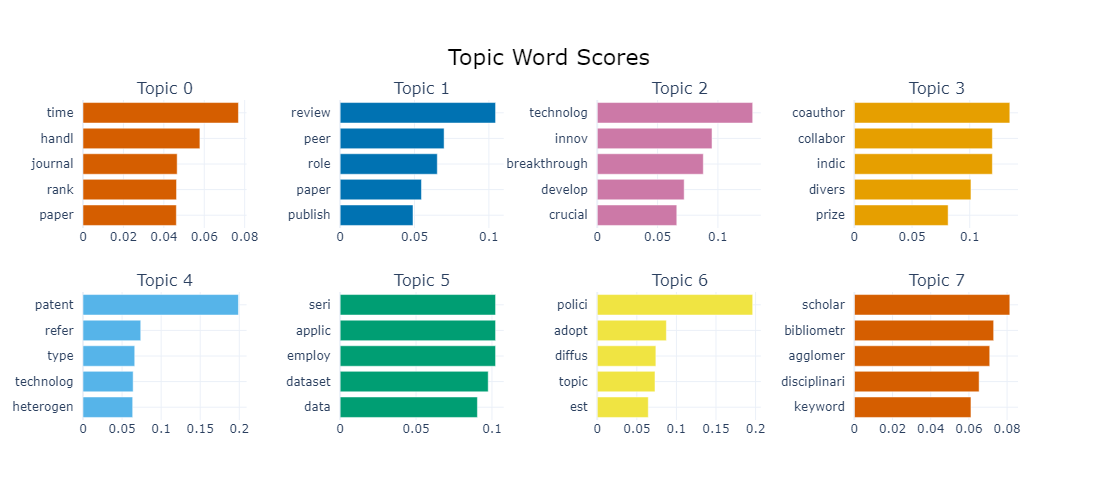

In [21]:
# 主题-词概率分布
topic_model.visualize_barchart()

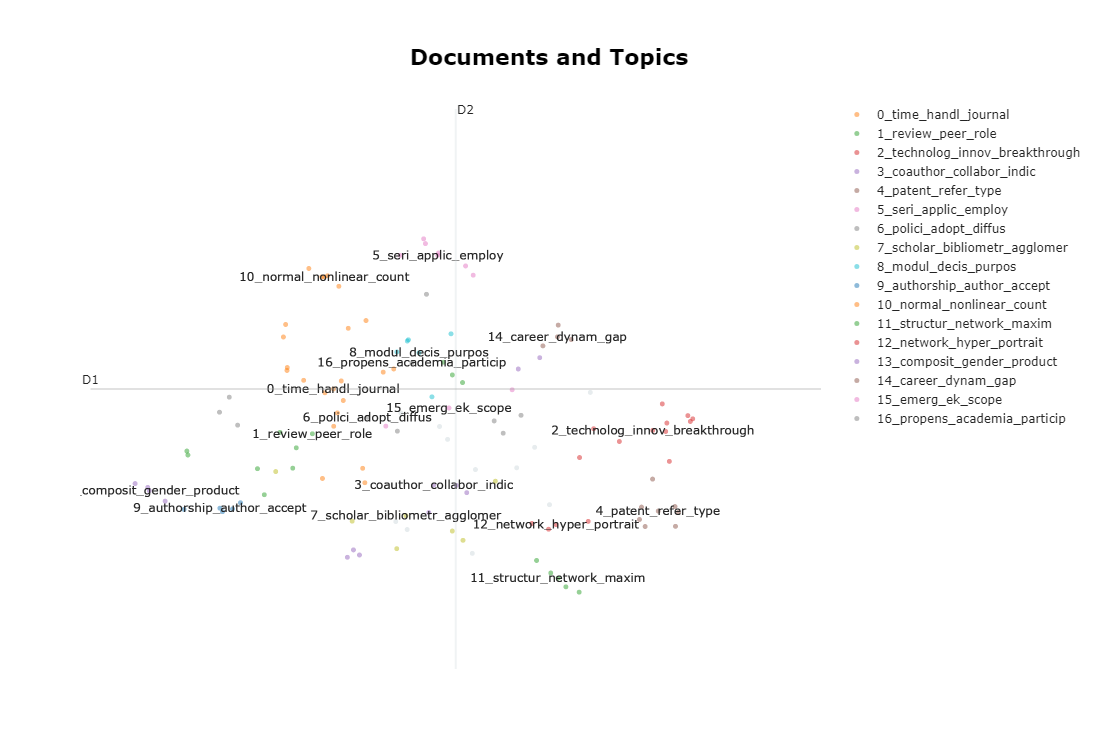

In [22]:
# 文档主题聚类
embeddings = embedding_model.encode(filtered_text, show_progress_bar=False)
 
# Run the visualization with the original embeddings
topic_model.visualize_documents(filtered_text, embeddings=embeddings)

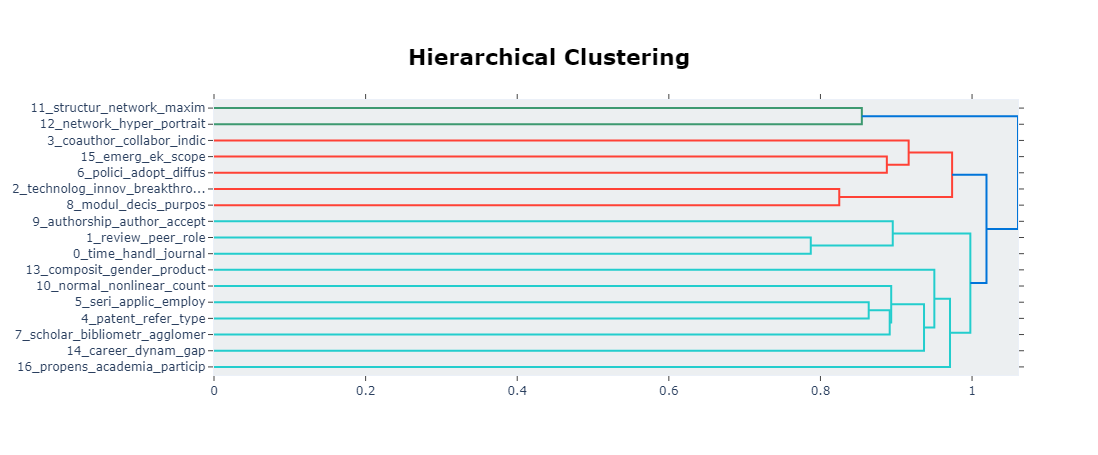

In [23]:
# 聚类分层
topic_model.visualize_hierarchy()

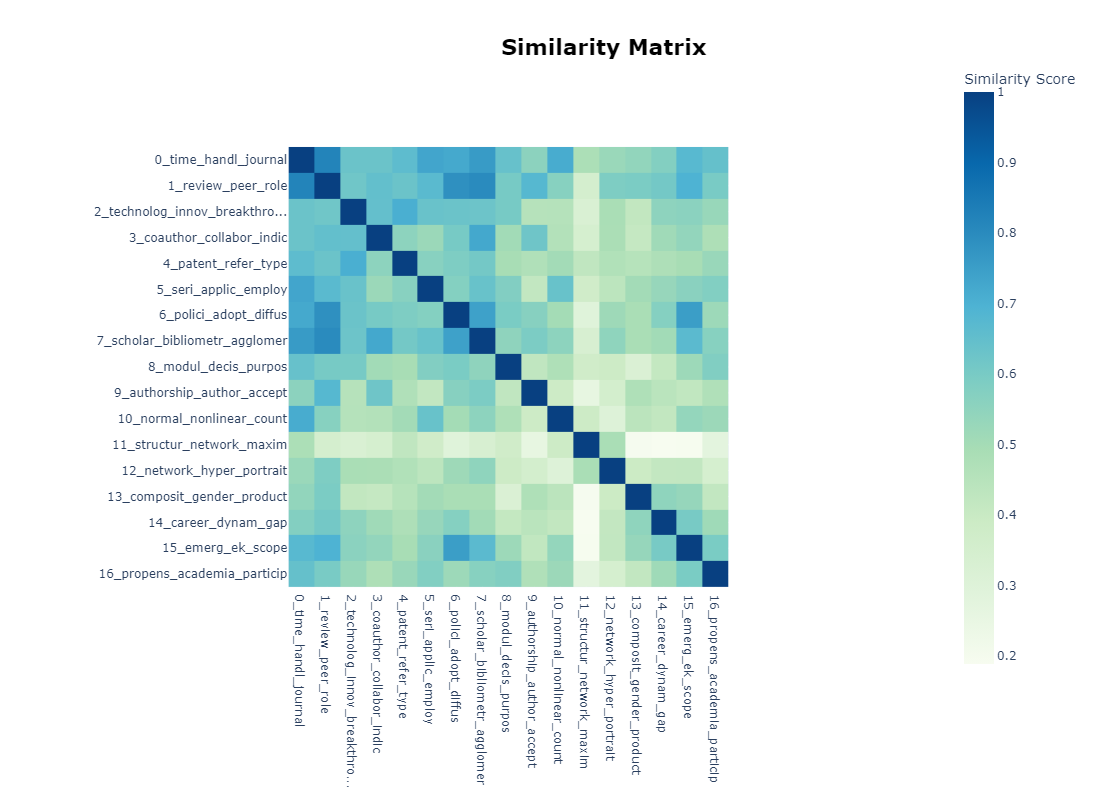

In [24]:
# 主题相似度热力图
topic_model.visualize_heatmap()

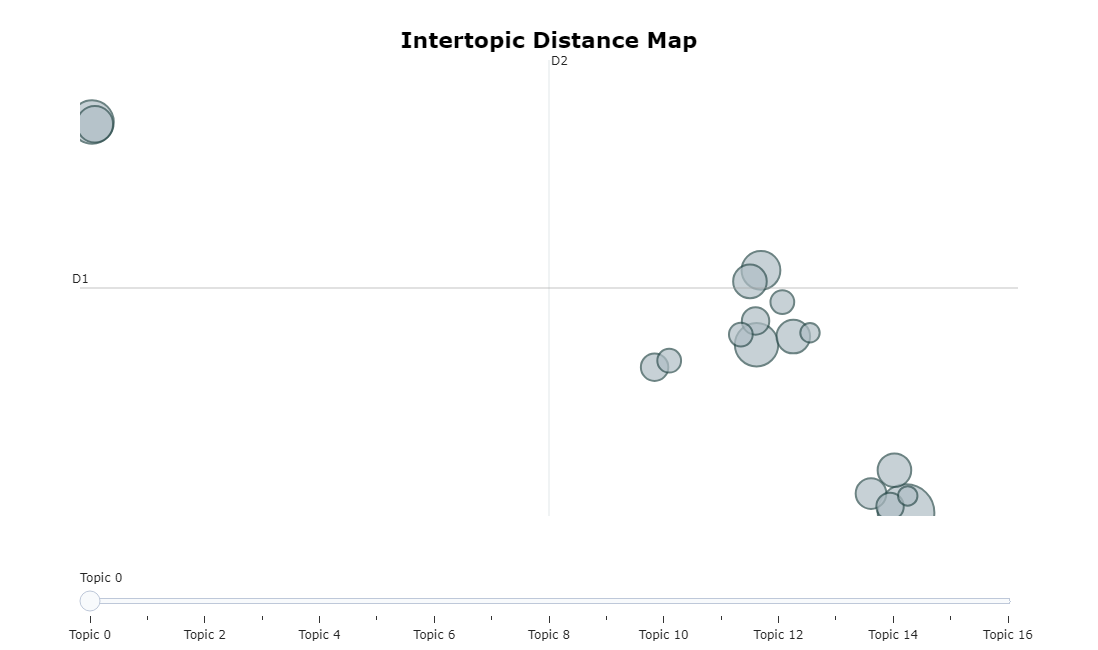

In [25]:
# 隐含主题主题分布图
topic_model.visualize_topics()